In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score

#These two functions we will use for data processing
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, MaxAbsScaler, RobustScaler, StandardScaler

#We want to create an unseen test set that we can use to get an estimate of our accuracy
from sklearn.model_selection import train_test_split
import time

In [3]:
#First we import the training set
train = pd.read_csv('../input/titanic/train.csv')
#train, dev = train_test_split(train, test_size = .1)

#Now we import the test set
test = pd.read_csv('../input/titanic/test.csv')

#There may be some additional information that we can get from these columns, but for ease of fitting we will just drop them
train = train.drop(['PassengerId'], axis = 1)

#In order to do our submission we need to preserve these. Then we can drop them
test_ids = test.PassengerId
test = test.drop(['PassengerId'], axis = 1)


train_labels = train.Survived
train = train.drop(['Survived'], axis = 1)


#get value of ticket number
train["Ticket"] = train["Ticket"].str.slice(stop=1).replace(to_replace ='[A-Z]', value = '3', regex = True) 
test["Ticket"] = test["Ticket"].str.slice(stop=1).replace(to_replace ='[A-Z]', value = '3', regex = True)


#get cabint number
train["Cabin"] = train["Cabin"] \
    .str.slice(stop=3) \
    .replace(to_replace = '[ A-Z]', value='', regex=True) \
    .replace(to_replace = '', value='0') \
    .fillna('0') \
    .astype('int') \
    .div(10) \
    .astype('int') \
             
test["Cabin"] = test["Cabin"] \
    .str.slice(stop=3) \
    .replace(to_replace = '[ A-Z]', value='', regex=True) \
    .replace(to_replace = '', value='0') \
    .fillna('0') \
    .astype('int') \
    .div(10) \
    .astype('int') \

#fill in nan
train["Age"] = train['Age'] \
    .fillna(30) \
    .astype('int')
test["Age"] = test['Age'] \
    .fillna(30) \
    .astype('int')
#train["Age"] = train["Age"].astype('int')
#test["Age"] = test["Age"].astype('int')

train["Fare"] = train["Fare"] \
    .fillna(7) \
    .astype('int')

test["Fare"] = test["Fare"] \
    .fillna(7) \
    .astype('int')

#make new features
train["standing"] = train["Ticket"] * train["Pclass"]   #* train['Age'].fillna(0).astype('int')
test["standing"] = test["Ticket"] * test["Pclass"]   #* test['Age'].fillna(0).astype('int')

train["money"] = train["Fare"] * 1 / train["Pclass"].div(3)   #* train['Age'].fillna(0).astype('int')
test["money"] = test["Fare"] * 1 / test["Pclass"].div(3)

train["gender_int"] = [1 if i == "female" else 2 for i in train["Sex"]]
test["gender_int"] = [1 if i == "female" else 2 for i in test["Sex"]]

#train["gender_class"] = train["Sex"].contains("female") * train["Pclass"] #* train['Age'].fillna(0).astype('int')
#test["gender_class"] = test["Sex"] * test["Pclass"]

train["wife"] = train["Name"].str.contains("Mrs.") 
#train["husband"] = train["Name"].str.contains("Mr.") + 1
train["female"] = train["Name"].str.contains("Miss.") + train["wife"] + 1
test["wife"] = test["Name"].str.contains("Mrs.")
#test["husband"] = test["Name"].str.contains("Mr.") + test["wife"]
test["female"] = test["Name"].str.contains("Miss.") + test["wife"] + 1

train["rich_female"] = train["money"] * train["female"]
test["rich_female"] = test["money"] * test["female"]

train["rich_female"] = train["rich_female"].div(10).astype('int')
test["rich_female"] = test["rich_female"].div(10).astype('int')

train["hot_ticket"] = ["high" if i >= 3 else "low" for i in train["Ticket"].astype('int')]
test["hot_ticket"] = ["high" if i >= 3 else "low" for i in test["Ticket"].astype('int')]



In [4]:
 #First we create our encoder
enc = OneHotEncoder()
drop_list = ["Sex", "Name", "Embarked", "Embarked_nan", "Embarked_Q", "Embarked_C", \
             "Pclass", "female", "Fare", "Sex_male", "Sex_female", 'hot_ticket', "Ticket"]

#We create new column names from the categories using `enc.get_feature_names_out(['Sex', 'Embarked'])`
#We fit the encoder to the training data and transform it simultaneously with the .fit_transform() method
train[enc.get_feature_names_out(['Sex', 'Embarked', 'hot_ticket'])] = enc.fit_transform(train[['Sex', 'Embarked', 'hot_ticket']]).toarray()

#We need to drop the original columns after
train = train.drop(drop_list, axis =1)


test[enc.get_feature_names_out(['Sex', 'Embarked', 'hot_ticket'])] = enc.transform(test[['Sex', 'Embarked', 'hot_ticket']]).toarray()
test = test.drop(drop_list, axis =1)
#First we create the scaler and fit it to our TRAINING DATA ONLY!
#We simultaneously transform it with .fit_transform

columns = train.columns

scaler = MinMaxScaler()
train = scaler.fit_transform(train)

#Now using the scaler fit to the training data, we transform dev and test
test = scaler.transform(test)



# Estimate by cross-validation of the optimal number of neighbors (k)

#The dictionary below is used by grid search. The keys in the dictionary need to be exactly
#what the params in the KNeighborsClassifier are called. The value needs to be a list of values to try.
#We will try to use between 1 and the number of features
k = {'n_neighbors': np.concatenate([np.arange(1, train.shape[1]+1)]).tolist()}

#Now we create the grid search object and fit it with our training data.
#It uses a subset of the data to get an accuracy. It repeats this process 5 time for each possible k we
#told it to try.
best_param_kNN = GridSearchCV(KNeighborsClassifier(p=1), k, scoring='accuracy', verbose = 3)
best_param_kNN.fit(train, train_labels)

#Now we express the best parameter and print it
optimal_k = best_param_kNN.best_params_['n_neighbors']

#Now we create our model using the optimal K
kNN = KNeighborsClassifier(n_neighbors=optimal_k, p=1)

#Now we "fit" the knn, and test it's accuracy with the dev set.
start_time = time.time()
cv_scores = cross_val_score(kNN, train, train_labels, cv=5)

# print (f'Accuracy using train data: {np.mean(cv_scores)}')
# print ('Train time and Predict Time = %.2f' %(time.time() - start_time))


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END .....................n_neighbors=1;, score=0.765 total time=   0.0s
[CV 2/5] END .....................n_neighbors=1;, score=0.725 total time=   0.0s
[CV 3/5] END .....................n_neighbors=1;, score=0.809 total time=   0.0s
[CV 4/5] END .....................n_neighbors=1;, score=0.753 total time=   0.0s
[CV 5/5] END .....................n_neighbors=1;, score=0.792 total time=   0.0s
[CV 1/5] END .....................n_neighbors=2;, score=0.788 total time=   0.0s
[CV 2/5] END .....................n_neighbors=2;, score=0.775 total time=   0.0s
[CV 3/5] END .....................n_neighbors=2;, score=0.803 total time=   0.0s
[CV 4/5] END .....................n_neighbors=2;, score=0.792 total time=   0.0s
[CV 5/5] END .....................n_neighbors=2;, score=0.848 total time=   0.0s
[CV 1/5] END .....................n_neighbors=3;, score=0.810 total time=   0.0s
[CV 2/5] END .....................n_neighbors=3;

In [5]:
kNN = KNeighborsClassifier(n_neighbors=optimal_k+1, p=1)

#Now we "fit" the knn, and test it's accuracy with the dev set.

kNN.fit(train, train_labels)


#Finally we make our predictions, zip them up with the passenger ids, and submit!
predictions =kNN.predict(test)

output = pd.DataFrame({'PassengerId': test_ids, 'Survived': predictions})
output.to_csv('submission.csv', index=False)
print('done')

done


Best alpha using built-in LassoCV: 0.000586
Best score using built-in LassoCV: 0.403508
Lasso picked 11 variables and eliminated the other 1 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

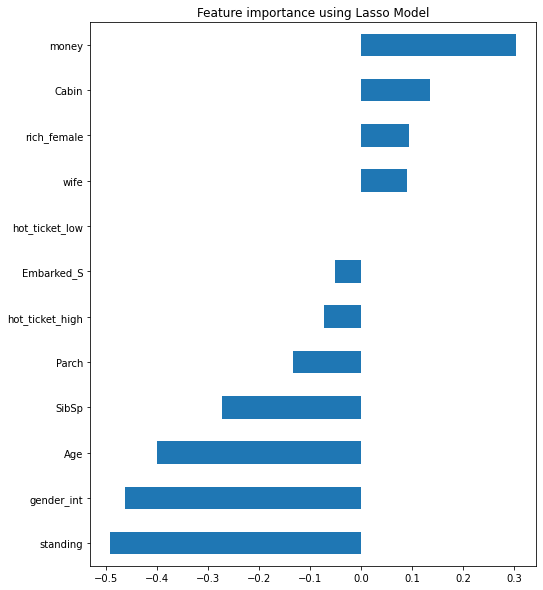

In [6]:
from sklearn.datasets import load_boston
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso#Loading the dataset

X = pd.DataFrame(train, columns=columns)
reg = LassoCV()
reg.fit(X, train_labels)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X,train_labels))
coef = pd.Series(reg.coef_, index = columns)

print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

In [7]:
# making new features

